In [210]:
%matplotlib notebook
# -*- coding: utf-8 -*-
"""
Created on Thu Feb 14 14:31:58 2019

@author: Damian

CHANGELOG:
    
    V0: 
    - Added JC Hamiltonian
    - Added drive Hamiltonian for flux control
    - Added pulse Hamiltonian for driving to excited state
    
    V1:
    - Added second oscillator
    - Added loss term for second oscillator
    - Expanded to periodic time of operators
    
    V2:
    - Transformed to rotating frame of the qubit Hamiltonian
    - Added Qutrit option(Nat1)
    - Added anharmonicity
    - Added Gaussian envelope for pulse 
    - Started plotting state occupancy rather than sx,sy,sz.
    
    V3:
    - Start of Notebook with cQED module of functions
    - Made sure no overlap in pulses can be created without deliberate intention.
    - Corrected time of cycle to # periods of oscillator
    - Added standard printing of file and settings for reproducability 
    - Added Wigner function plot
    
    EXTRA NOTES:
        - periodicity/phase of osc is a potential problem.
        A cycle must be an integer number of periods of the oscillator for superradiance.
        - Wiggles seen in osc 1(and 2) due to g. Yes, this is correct!
        - In excited state emission is linear in N
        - In superposition state emission is quadratic in N
        - How to implement sx,sy,sz with qutrit?
        - Need to apply DRAG pulse, I believe. (? Appears to be fine without drag)
        Excited state becomes occupied due to Gaussian pulse and decays slowly.
        
    CHECKS TO BE DONE AND DOCUMENTED:
        - Turn off g of osc when drive not active.
        - Change g to smaller values. ( ~50% Done)
        - Try second order sideband processes
        
    
    Observations:
        -Simply rotating Lindblad operators are not proper. Are corrections truly necessary?
        
        
    
"""

from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import cQED
import time
eps = np.finfo(float).eps

In [211]:
N1=10                 # Number of levels in cavitie 1
N2=2                  # Number of levels in cavitie 1
Nat1=3                # Number of levels in transmons

##Parameters of Hamiltonians
wc1 = 2*np.pi*5.2     # Cavity 1 frequency
wc2 = 2*np.pi*5.2     # Cavity 2 frequency

wa = 2*np.pi*5.2        # Transmon frequency 1
E = -2*np.pi*0.16      # Anharmonicity

g1 = 2*np.pi*0.001    # Coupling strength to cavity 1
g2 = 2*np.pi*0.003   # Coupling strength to cavity 2

##Flux modulation parameters
td1=0.0               # Atom driving time 1
td2=350               # Atom driving time 2
wd1=wa-wc1            # Atom driving frequency 1
wd2=wa-wc2            # Atom driving frequency 2
# eps1=1.84*wd1         # Atom driving strength 1
# eps2=1.84*wd2         # Atom driving strength 2
tstep=1               # Step time

##Microwave pulse parameters
tpulse=60               # Pulse time [?]
Omega=1*np.pi/tpulse*(1) # Initializing pulse strength
wp=2*np.pi*5.2             # Pumping/rotating frame frequency

##Dephasing time
OmegaDephase=2*np.pi*6.0-2*np.pi*5.2 
Tdephase=2*np.pi/OmegaDephase

In [212]:
##Define cycle times
t0=30
t1=t0+td1
t2=t1+30
t3=t2+td2
t4=t3+100
t5=t4+tpulse

deltau=t5    ##Cycle time
# deltau=t5+Tdephase-((t5+Tdephase)%Tdephase)+0*Tdephase    ##Cycle time
num=int(2)           ##Number of cycles
tau=deltau*num       ##Total simulation time

In [213]:
##Cavity mode operators
a1 = tensor(destroy(N1), qeye(N2), qeye(Nat1))
a2 = tensor(qeye(N1), destroy(N2), qeye(Nat1))

##Transmon operators
c = tensor(qeye(N1),qeye(N2), destroy(Nat1)) 
n=c.dag()*c

S1=tensor(qeye(N1),qeye(N2),fock_dm(Nat1, 0))
S2=tensor(qeye(N1),qeye(N2),fock_dm(Nat1, 1))
S3=tensor(qeye(N1),qeye(N2),fock_dm(Nat1, 2))




##The Jaynes-Cummings Hamiltonian in the rotating frame
Hjc = ((wc1-wp) * a1.dag() * a1
       + (wc2-wp) * a2.dag() * a2 
       + 0.5 * (wa-wp) * n+0.5*E*c.dag()*c.dag()*c*c)

##Couplings Hamiltonians
Hc1=g1 * (a1 * c.dag() + a1.dag() * c)
Hc2=g2 * (a2 * c.dag() + a2.dag() * c)

# ##Flux modulation Hamiltonian
# Hd1=0.5 * eps1 * n 
# Hd2=0.5 * eps2 * n 


##Pump Hamiltonian
Hp=0.5*Omega*(c.dag()+c)

In [214]:
##Define problem for solver and run

##Full H
#H = [Hjc, [Hd1, cQED.Resonance1],[Hd2, cQED.Resonance2],Hc1,Hc2,[Hp,cQED.PumpQubit]]
H = [Hjc, [Hc1, cQED.Resonance1],[Hc2, cQED.Resonance2],[Hp,cQED.PumpQubit]]
#H = [Hjc, Hc2]
H_args = {"t0": t0, "t1" : t1 , "t2" : t2 , "t3" : t3 , "t4" : t4 , "t5" : t5 , 
          "td1" : td1, "td2" : td2,'tpulse':tpulse,'deltau':deltau,'wd1':wd1,'wd2':wd2,'tstep':tstep}


##Define operators for losses+decoherence
#rate=0.31;
rate=2.0*g2;
O1=np.sqrt(rate)*a2;

c_op_list=[O1]

##Define initial state
psi0=tensor(basis(N1,0),basis(N2,0),(basis(Nat1,0)-1j*basis(Nat1,1))/np.sqrt(2))
# psi0=tensor(basis(N1,0),basis(N2,0),basis(Nat1,1))

## list of times for which the solver should store the state vector
Npoints=1000
tlist = np.linspace(0, tau, Npoints)
#tlist = np.linspace(0, tau, num+1)

options=Options()
options.nsteps=10000
options.rtol=10**(-10)
options.store_states=True
options.max_step=0.1

e_ops = [a1.dag()*a1,
         a2.dag()*a2, 
         c.dag()*c,
         S1, S2, S3]

result =  mesolve(H, psi0, tlist, c_op_list, e_ops, args=H_args, options=options)
Now=time.asctime()
Now=Now.replace(" ", "_")
Now=Now.replace(":", "-")

<IPython.core.display.Javascript object>


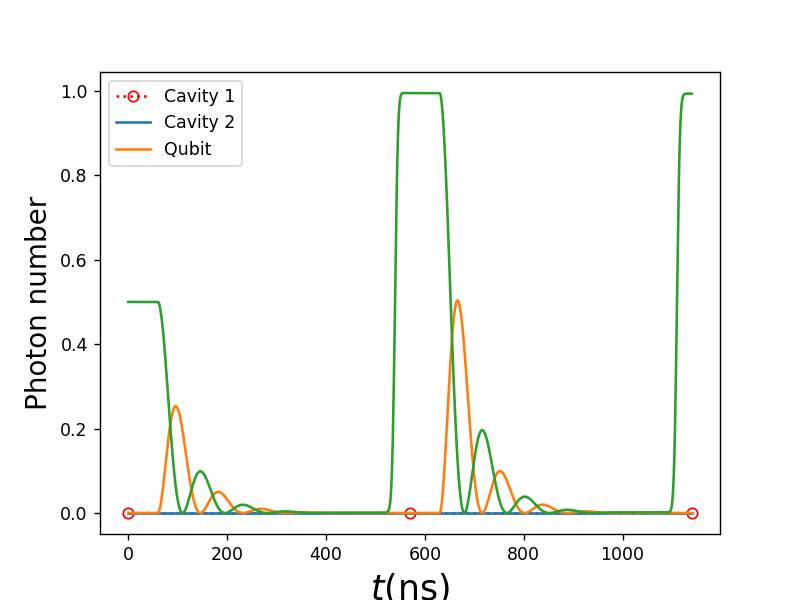

<IPython.core.display.Javascript object>


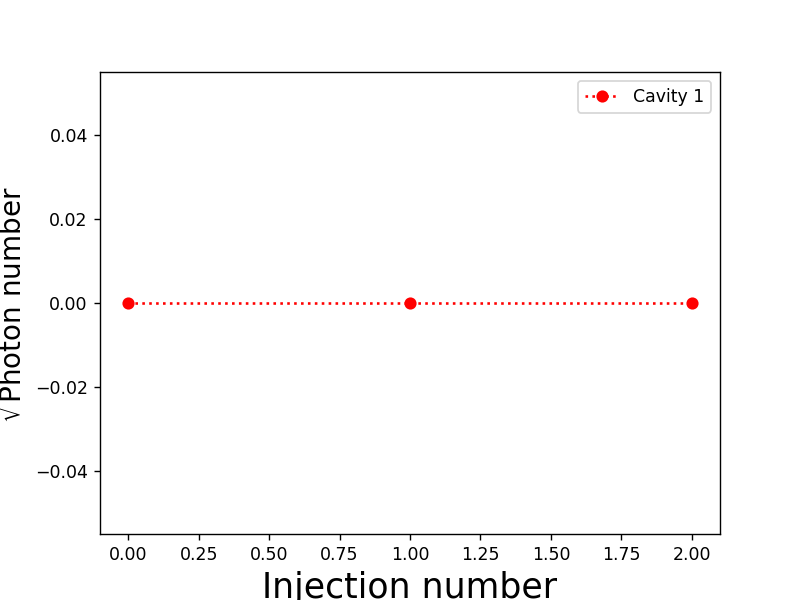

<IPython.core.display.Javascript object>


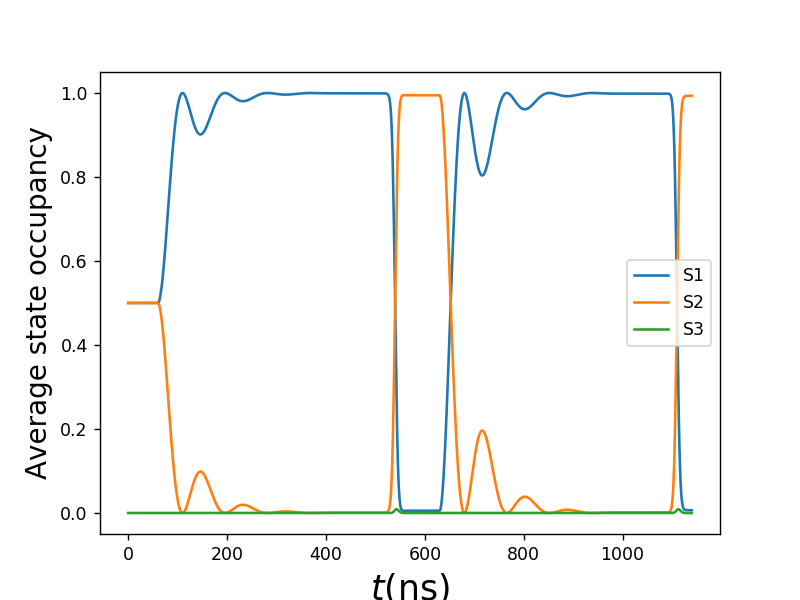

In [215]:
##Plotting and saving of parameters and data is implemented here
Name='TestV2'+Now

ts=np.linspace(0,Npoints-1,num+1,dtype=np.int32)  ##Vector for sampling once each cycle

##PLOTTING
fig1, axes1 = plt.subplots(1,1)
axes1.plot(tlist[ts], result.expect[0][ts],':or',fillstyle='none')
axes1.plot(tlist, result.expect[0])
axes1.plot(tlist, result.expect[1])
axes1.plot(tlist, result.expect[2])
axes1.set_xlabel(r'$t$(ns)', fontsize=20)
axes1.set_ylabel(r"Photon number", fontsize=16);
axes1.legend(["Cavity 1 Steps","Cavity 1","Cavity 2","Qubit"])
axes1.legend(["Cavity 1","Cavity 2","Qubit"])
# fig1.savefig(Name+'N.pdf')

fig1b, axes1b = plt.subplots(1,1)
axes1b.plot(np.linspace(0,num,num+1), np.sqrt(result.expect[0][ts]),'o:r')
axes1b.set_xlabel(r'Injection number', fontsize=20)
axes1b.set_ylabel(r"$\sqrt{\mathrm{Photon\ number}}$", fontsize=16);
axes1b.legend(["Cavity 1 Steps","Cavity 1","Cavity 2","Qubit"])
axes1b.legend(["Cavity 1","Cavity 2","Qubit"])
# fig1b.savefig(Name+'N2.pdf')

fig2, axes2 = plt.subplots(1,1)
axes2.plot(tlist, result.expect[3])
axes2.plot(tlist, result.expect[4])
axes2.plot(tlist, result.expect[5])
axes2.set_xlabel(r'$t$(ns)', fontsize=20)
axes2.set_ylabel(r"Average state occupancy", fontsize=16);
axes2.legend(["S1","S2","S3"])
# fig2.savefig(Name+'S.pdf')

In [216]:
result.expect[2]

array([5.00000000e-01, 5.00000000e-01, 5.00000000e-01, 5.00000000e-01,
       5.00000000e-01, 5.00000000e-01, 5.00000000e-01, 5.00000000e-01,
       5.00000000e-01, 5.00000000e-01, 5.00000000e-01, 5.00000000e-01,
       5.00000000e-01, 5.00000000e-01, 5.00000000e-01, 5.00000000e-01,
       5.00000000e-01, 5.00000000e-01, 5.00000000e-01, 5.00000000e-01,
       5.00000000e-01, 5.00000000e-01, 5.00000000e-01, 5.00000000e-01,
       5.00000000e-01, 5.00000000e-01, 5.00000000e-01, 5.00000000e-01,
       5.00000000e-01, 5.00000000e-01, 5.00000000e-01, 5.00000000e-01,
       5.00000000e-01, 5.00000000e-01, 5.00000000e-01, 5.00000000e-01,
       5.00000000e-01, 5.00000000e-01, 5.00000000e-01, 5.00000000e-01,
       5.00000000e-01, 5.00000000e-01, 5.00000000e-01, 5.00000000e-01,
       5.00000000e-01, 5.00000000e-01, 5.00000000e-01, 5.00000000e-01,
       5.00000000e-01, 5.00000000e-01, 5.00000000e-01, 4.99999999e-01,
       4.99996858e-01, 4.99758972e-01, 4.98153727e-01, 4.94702343e-01,
      

In [217]:
# ##Output variables into settings file
# f = open(Name+"Settings.py",'w')
# f.write('N1 = ' + str(N1) + '\n')
# f.write('N2 = ' + str(N2) + '\n')
# f.write('Nat1 = ' + str(Nat1) + '\n')
# f.write('wc1 = ' + str(wc1) + '\n')
# f.write('wc2 = ' + str(wc2) + '\n')
# f.write('wa = ' + str(wa) + '\n')
# f.write('E = ' + str(E) + '\n')
# f.write('g1 = ' + str(g1) + '\n')
# f.write('g2 = ' + str(g2) + '\n')
# f.write('td1 = ' + str(td1) + '\n')
# f.write('td2 = ' + str(td2) + '\n')
# f.write('eps1 = ' + str(eps1) + '\n')
# f.write('eps2 = ' + str(eps2) + '\n')
# f.write('tpulse = ' + str(tpulse) + '\n')
# f.write('wp = '  + str(wp) + '\n')
# f.write('tau= ' + str(tau)+'\n')
# f.write('Npoints= ' + str(Npoints)+'\n')
# f.close()

# qsave(result.states[0:Npoints:1], Name+"States")

<IPython.core.display.Javascript object>


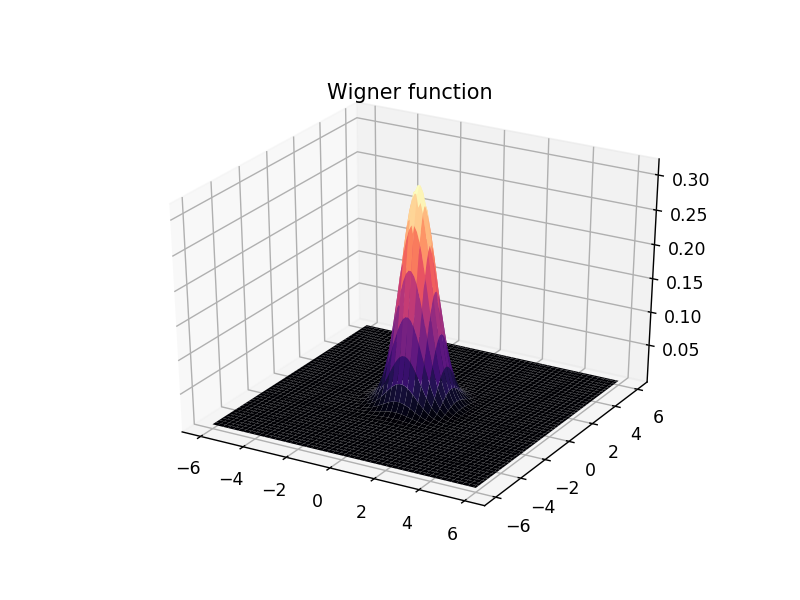

<IPython.core.display.Javascript object>


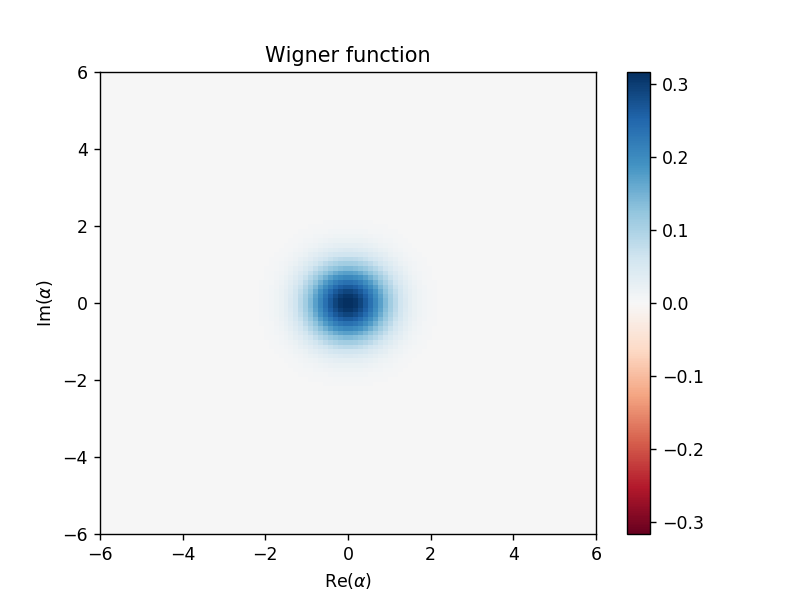

<IPython.core.display.Javascript object>


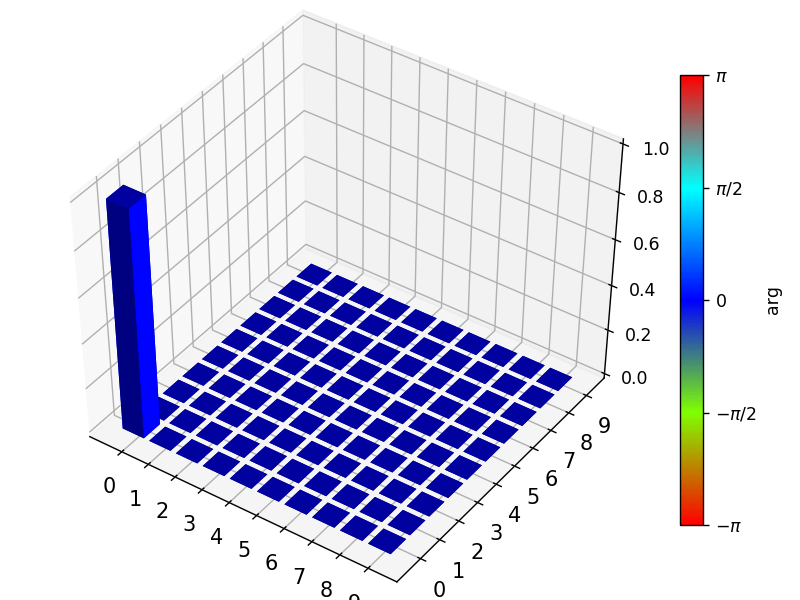

<IPython.core.display.Javascript object>


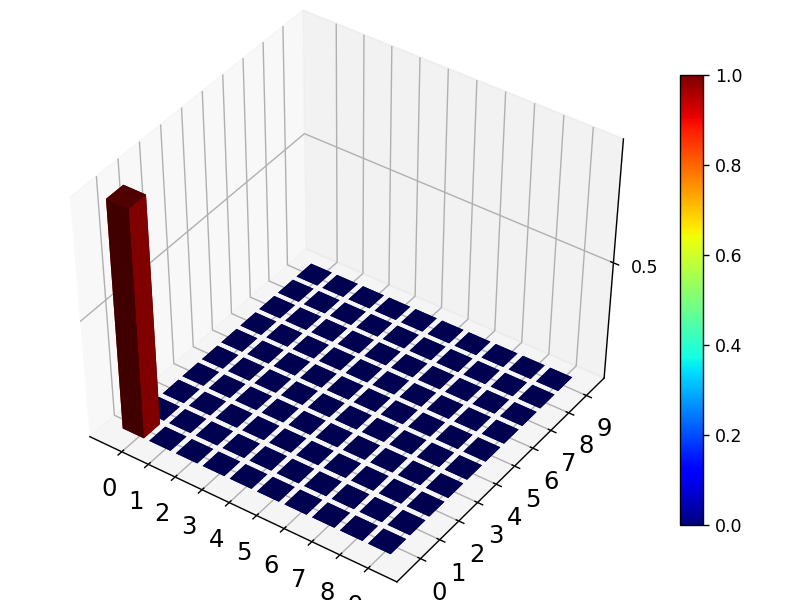

In [218]:
ind=int(999)

a=tensor(destroy(N1))
n=a.dag()*a

t=np.linspace(0,tau,Npoints)
Delta=wa-wc1
U=(-1j*n*(-Delta)*t[ind]).expm() ##Rotating frame transformation

SubSystem=0;


x=np.linspace(-6,6,100)
p=np.linspace(-6,6,100)
psi=result.states[ind]
W=wigner(psi.ptrace(SubSystem),x,p)
wmap = wigner_cmap(W)

X, P = np.meshgrid(x, p)

## Show Wigner function in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, P, W, cmap=cm.magma)
plt.title('Wigner function')
plt.show()

## Show Wigner function in 2D
fig=plt.figure()
plt.title('Wigner function')
p = plt.imshow(W,extent=(np.amin(x), np.amax(x), np.amin(p), np.amax(p)), aspect = 'auto',cmap='RdBu')
p.set_clim([-np.amax(W),np.amax(W)])
plt.colorbar()
plt.xlabel(r"Re($\alpha$)")
plt.ylabel(r"Im($\alpha$)")
plt.show()
# fig.savefig(Name+'Wigner2D.pdf')

##Show State Tomography of cavity 1.
fig1, ax1 = matrix_histogram_complex(U.dag()*psi.ptrace(SubSystem)*U)
ax1.view_init(azim=-55, elev=45)
plt.show()
# fig1.savefig(Name+'STomography.pdf')

fig2, ax2 = matrix_histogram(psi.ptrace(SubSystem))
ax2.view_init(azim=-55, elev=45)
plt.show()